<a href="https://colab.research.google.com/github/rehsani/ResBazAZ2021/blob/main/ResBazAZ_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Machine Learning Project


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1HfyjhT_62wWvmUqoP8yJiVOE3JuK1ZmN#scrollTo=oLNgPO853WWa"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this part of the workshop, we will work through an example project end to end. Here are the main steps we will go through (of course, if we have enough time):

*   Look at the big picture.

*   Get the data.

*   Discover and visualize the data to gain insights.

*   Prepare the data for Machine Learning algorithms.

*   Select a model and train it.


## Wroking with Real Data

When you are learning about Machine Learning, it is best to experiment with real-world data, not artificial datasets. Fortunately, there are thousands of open datasets to choose from, ranging across all sorts of domains. Here are a few places you can look to get data:

* UC Irvine Machine Learning Repository

* Kaggle datasets

* Amazon’s AWS datasets

Here, we’ll use the **California Housing Prices dataset** from the StatLib repository. This dataset is based on data from the 1990 California census. It is not exactly recent (a nice house in the Bay Area was still affordable at the time), but it has many qualities for learning, so we will pretend it is recent data. For teaching purposes I’ve added a categorical attribute and removed a few features.


In [22]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Get the Data

It’s time to get your hands dirty. Don’t hesitate to pick up your laptop and walk through the following code examples in a Jupyter notebook/Google Colab. The full notebook is available here.




In [23]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [24]:
fetch_housing_data()

In [25]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [26]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes: longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, and ocean_proximity.

The info() method is useful to get a quick description of the data, in particular the total number of rows, each attribute’s type, and the number of nonnull values.



In [27]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards, but it’s perfect to get started. Notice that the total_bedrooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. We will need to take care of this later.

All attributes are **numerical**, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object. But since you loaded this data from a CSV file, you know that it must be a text attribute. When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a **categorical** attribute. You can find out what categories exist and how many districts belong to each category by using the value_counts() method:

In [28]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let’s look at the other fields. The describe() method shows a summary of the numerical attributes.



In [29]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for example, the count of total_bedrooms is 20,433, not 20,640). The std row shows the standard deviation, which measures how dispersed the values are The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall. For example, 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or first quartile), the median, and the 75th percentile (or third quartile).


---


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the hist() method on the whole dataset (as shown in the following code example), and it will plot a histogram for each numerical attribute:




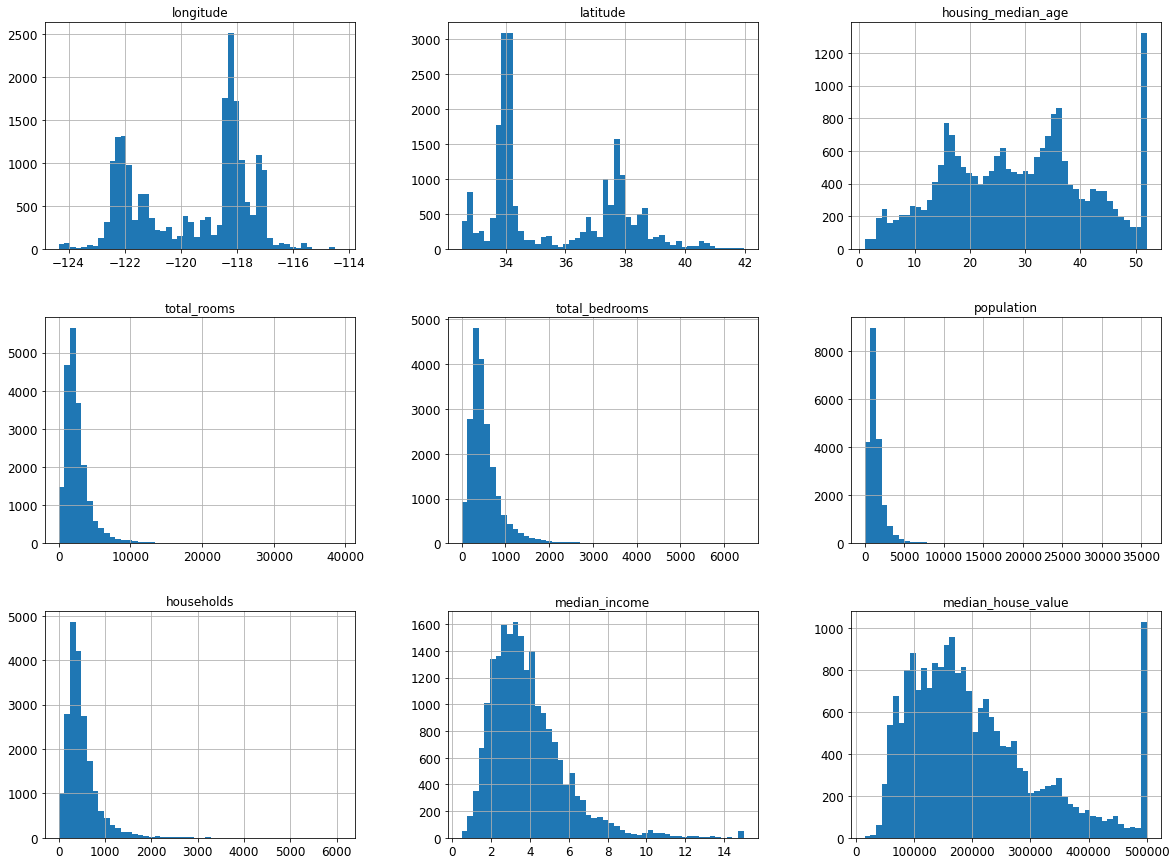

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

There are a few things you might notice in these histograms:

* First, the median income attribute does not look like it is expressed in US dollars (USD). The data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

* The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with the team that will use your system’s output to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:

1.  Collect proper labels for the districts whose labels were capped.

2. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

* These attributes have very different scales.

* Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. **This may make it a bit harder for some Machine Learning algorithms to detect patterns**. 

Hopefully you now have a better understanding of the kind of data you are dealing with.

## Create a Test Set

It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected. This is called **data snooping bias**.

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split(). First, there is a random_state parameter that allows you to set the random generator seed. Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):




In [31]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Discover and Visualize the Data to Gain Insights

So far you have only taken a quick glance at the data to get a general understanding of the kind of data you are manipulating. Now the goal is to go into a little more depth.

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small, so you can just work directly on the full set. Let’s create a copy so that you can play with it without harming the training set:

In [32]:
housing = train_set.copy()

## Visualizing Geographical Data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data:



<AxesSubplot:xlabel='longitude', ylabel='latitude'>

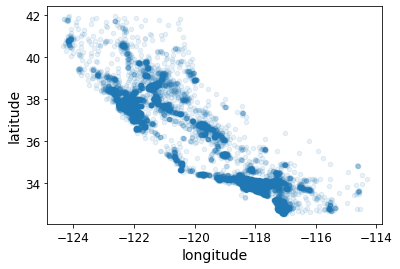

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


Our brains are very good at spotting patterns in pictures, but you may need to play around with visualization parameters to make the patterns stand out.

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):16




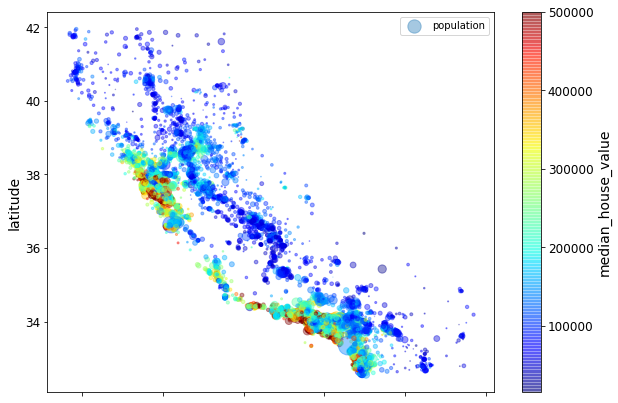

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method. Now let’s look at how much each attribute correlates with the median house value:


In [35]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to 0 mean that there is no linear correlation. Next figure shows various plots along with the correlation coefficient between their horizontal and vertical axes.

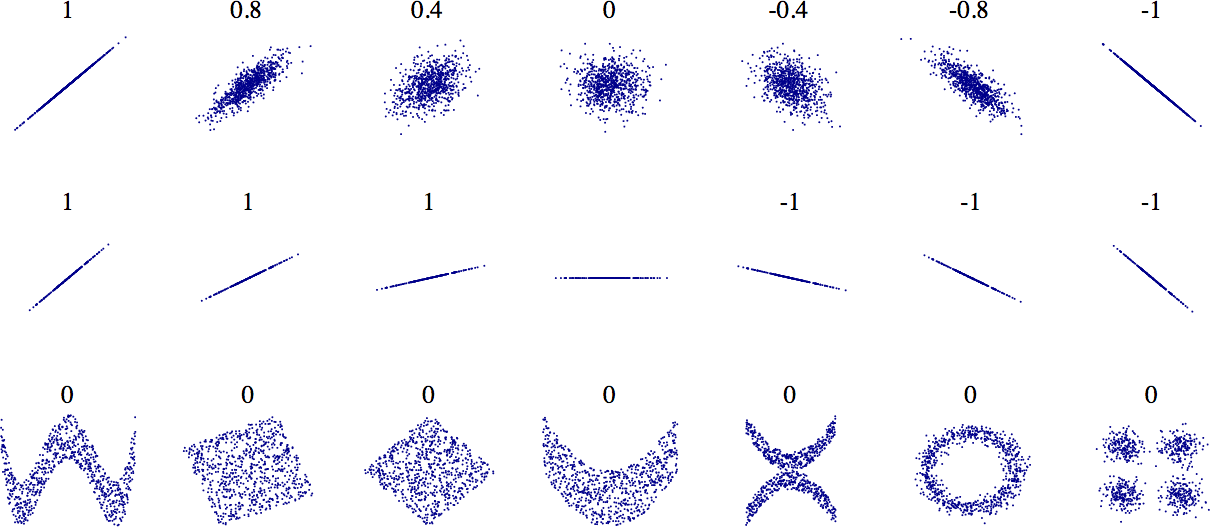


The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to 0, then y generally goes up”). Note how all the plots of the bottom row have a correlation coefficient equal to 0, despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships. Also, the second row shows examples where the correlation coefficient is equal to 1 or –1; notice that this has nothing to do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page—so let’s just focus on a few promising attributes that seem most correlated with the median housing value.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

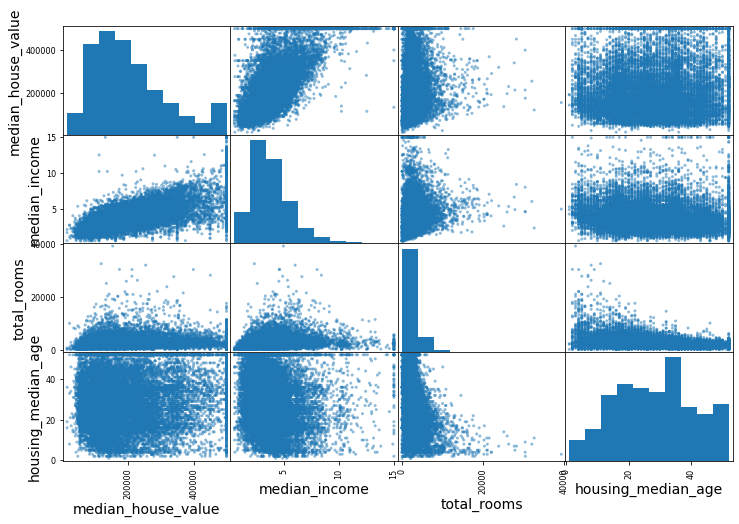

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot:



<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

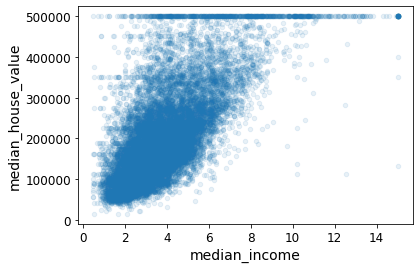

In [37]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at 500,000 USD. But this plot reveals other less obvious straight lines: a horizontal line around 450,000 USD, another around 350,000 USD, perhaps one around 280,000 USD, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

# Prepare the Data for Machine Learning Algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose, for several good reasons:

* This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).

* You will gradually build a library of transformation functions that you can reuse in future projects.

* You can use these functions in your live system to transform the new data before feeding it to your algorithms.

* This will make it possible for you to easily try various transformations and see which combination of transformations works best.

But first let’s revert to a clean training set (by copying train_set once again). Let’s also separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect train_set):

In [38]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

* Get rid of the corresponding districts.

* Get rid of the whole attribute.

* Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

In [39]:
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

##  Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but now let’s look at text attributes. In this dataset, there is just one: the **ocean_proximity** attribute. Let’s look at its value for the first 10 instances:

In [40]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR OCEAN
14265,NEAR OCEAN
2271,INLAND
17848,<1H OCEAN
6252,<1H OCEAN
9389,NEAR BAY
6113,<1H OCEAN
6061,<1H OCEAN


It’s not arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute. Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class:



In [41]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [4.],
       [4.],
       [4.],
       [1.],
       [0.],
       [0.],
       [3.],
       [0.],
       [0.]])

You can get the list of categories using the categories_ instance variable. It is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):



In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:20

In [43]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [44]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

# Select and Train a Model

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, cleaned up and prepare your data for Machine Learning algorithms automatically. You are now ready to select and train a Machine Learning model.

## Training and Evaluating on the Training Set

The good news is that thanks to all these previous steps, things are now going to be much simpler than you might think. Let’s first train a Linear Regression model, like we did in the previous session:



In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing.iloc[:, :-1], housing_labels)

LinearRegression()

Done! We now have a working Linear Regression model. Let’s try it out on a few instances from the training set:



In [46]:
some_data = housing.iloc[:5, :-1]
some_labels = housing_labels.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [181313.23430337 286451.78145112 263328.07605752 140991.31402388
 177337.39815452]
Labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error() function:



In [47]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing.iloc[:, :-1])
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69362.3413523808

This is better than nothing, but clearly not a great score: most districts’ median_housing_values range between 120,000 USD and 265,000 USD, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous session, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.

Let’s train a **DecisionTreeRegressor**. This is a powerful model, capable of finding complex nonlinear relationships in the data. The code should look familiar by now:

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing.iloc[:, :-1], housing_labels)

DecisionTreeRegressor()

Now that the model is trained, let’s evaluate it on the training set:


In [49]:
housing_predictions = tree_reg.predict(housing.iloc[:, :-1])
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

## Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:


In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing.iloc[:, :-1], housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70418.23296262 71705.45189707 69590.60384815 69332.75532905
 70399.48997007 67341.04244896 68482.59655954 69279.16365386
 69918.84711061 70640.40487062]
Mean: 69710.85886505307
Standard deviation: 1154.5020402034393


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

Let’s compute the same scores for the Linear Regression model just to be sure:

In [52]:
lin_scores = cross_val_score(lin_reg, housing.iloc[:, :-1], housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66170.13482881 72783.99723185 68950.52987763 67640.0509114
 70438.49542911 66523.65704676 66541.25492139 70992.53769382
 74292.46725992 70675.67306462]
Mean: 69500.8798265314
Standard deviation: 2659.043850886444


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called **Ensemble Learning**, and it is often a great way to push ML algorithms even further.

In [53]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing.iloc[:, :-1], housing_labels)

housing_predictions = forest_reg.predict(housing.iloc[:, :-1])
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18429.493408603772

In [55]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing.iloc[:, :-1], housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [47305.26980074 52231.6181588  48540.49274968 50562.42947377
 51376.21650418 46826.08586464 46042.37228201 51944.64322683
 50396.13608434 50183.11109261]
Mean: 49540.837523759714
Standard deviation: 2101.963075144401


Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before you dive much deeper into Random Forests, however, you should try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.


## Evaluate Your System on the Test Set
After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()—you do not want to fit the test set!), and evaluate the final model on the test set:

final_predictions = final_model.predict(X_test)
